### Hilbert DDPM for 1D toy example

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from util import gp_sampler,np2torch,kernel_se,get_rkhs_proj
from ddpm import get_ddpm_constants,plot_ddpm_constants,get_ddpm_loss,eval_hddpm_1D
from model import DenoisingDenseUNetClass
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Diffusion constants

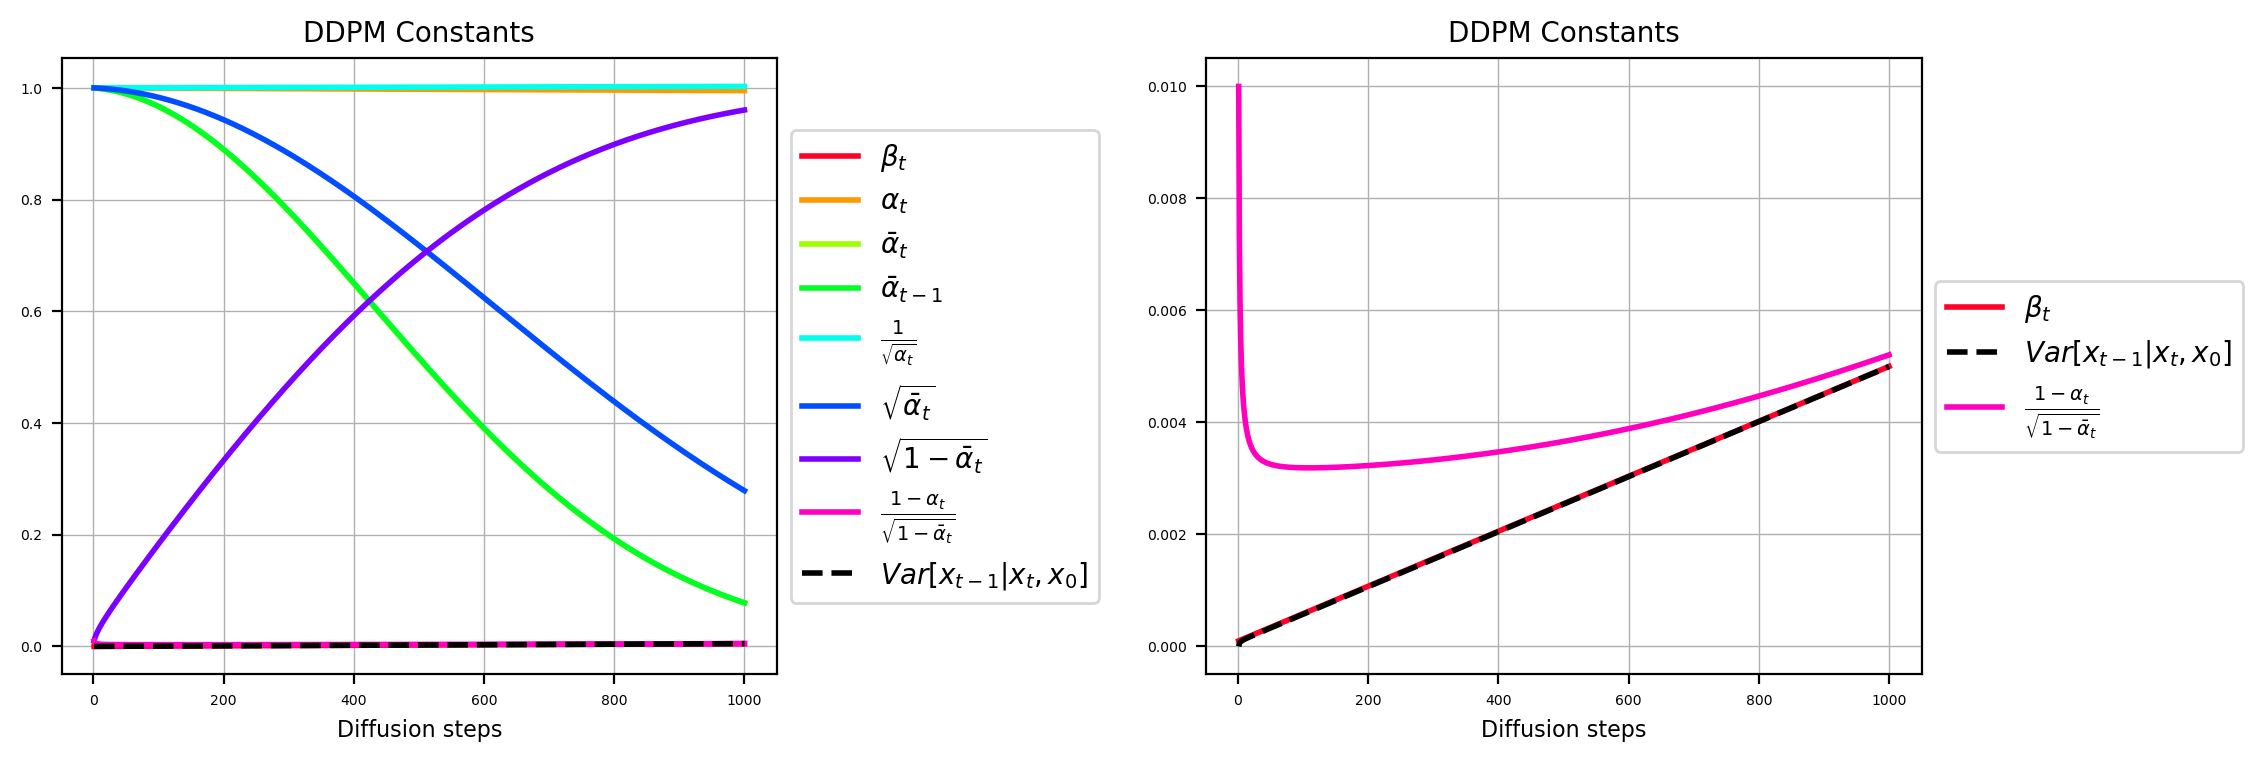

In [2]:
# Smaller `beta_end` tends to show better performances
dc = get_ddpm_constants(beta_start=1e-4,beta_end=5e-3,diffusion_step=1000)
plot_ddpm_constants(dc,figsize=(12,4))

### Commmon hyper-parameters

In [3]:
BATCH_SIZE,D,L = 128,1,100
base_lr,MAX_ITER = 1e-3,200000
actv = nn.ReLU() # nn.GELU(), nn.ReLU()
l1_w,l2_w,huber_w,smt_l1_w = 1.0,10.0,0.0,0.0
vel_w,acc_w = 0.0,1e-6
device = 'cpu' # cpu / mps
print ("Ready.")

Ready.


### Training data

In [4]:
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]

In [5]:
V_np,A_np = np.zeros(shape=(L,L)),np.zeros(shape=(L,L)) # [L x L]
for l_idx in range(L):
    if l_idx == 0: # all zeros at the first row
        DO_NOTHING = True
    elif l_idx == 1: # for the second row
        V_np[l_idx,0],V_np[l_idx,1] = -1,+1
        A_np[l_idx,0],A_np[l_idx,1] = 0,0
    else: # for the rest of the rows
        V_np[l_idx,l_idx-1],V_np[l_idx,l_idx] = -1,+1
        A_np[l_idx,l_idx-2],A_np[l_idx,l_idx-1],A_np[l_idx,l_idx] = +1,-2,+1
dt = times[1]-times[0]
V_np,A_np = V_np/dt,A_np/(dt*dt) # [L x L]
V,A = np2torch(V_np),np2torch(A_np)
print ("Ready.")

Ready.


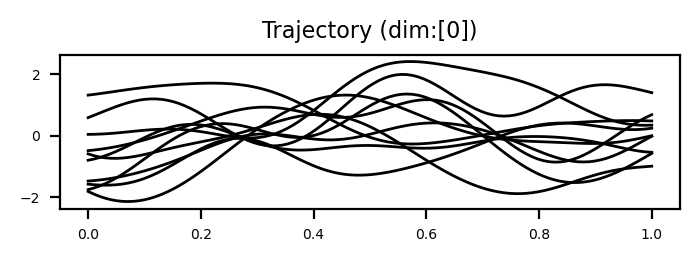

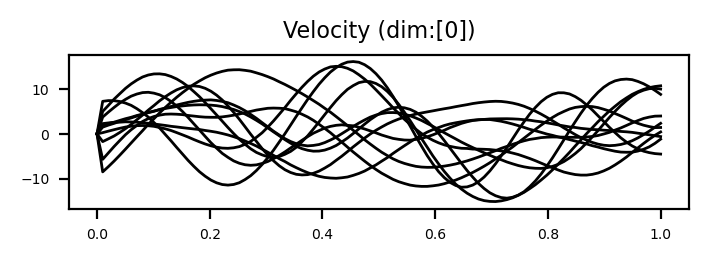

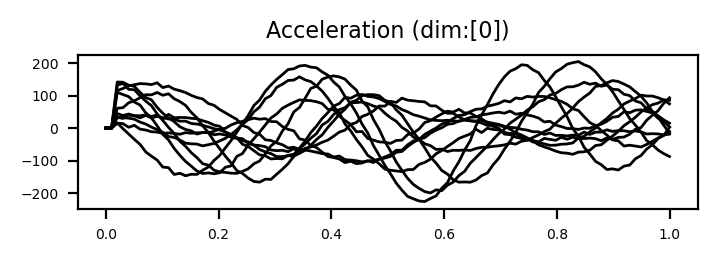

Ready.


In [6]:
USE_SINGLE_TRAJECTORY = False
if USE_SINGLE_TRAJECTORY:
    np.random.seed(seed=3)
    x_0_np = gp_sampler(times=times,hyp_gain=1.0,hyp_len=0.2,meas_std=1e-8,n_traj=D).T # [D x L]
    x_0 = np2torch(x_0_np,device=device) # [D x L]
    x_batch = torch.tile(x_0[None,:,:],dims=(BATCH_SIZE,1,1)) # [B x D x L]
    plt.figure(figsize=(3*D,1))
    for d_idx in range(D):
        plt.subplot(1,D,d_idx+1)
        plt.plot(times[:,0],x_0_np[d_idx,:],ls='-',color='k',lw=1)
        plt.title('dim:[%d]'%(d_idx),fontsize=8)
    plt.show()
else:
    M = 10 # total number of trajectories per dimension
    x_0_np = np.zeros(shape=(M,D,L)) # [M x D x L]
    for d_idx in range(D):
        x_0_np_d = gp_sampler(times=times,hyp_gain=1.0,hyp_len=0.2,meas_std=1e-8,n_traj=M).T # [M x L]
        x_0_np[:,d_idx,:] = x_0_np_d
    x_0 = np2torch(x_0_np) # [M x D x L]
    plt.figure(figsize=(4*D,1))
    for d_idx in range(D):
        plt.subplot(1,D,d_idx+1)
        for m_idx in range(M):
            plt.plot(times[:,0],x_0_np[m_idx,d_idx,:],ls='-',color='k',lw=1)
        plt.title('Trajectory (dim:[%d])'%(d_idx),fontsize=8)
    plt.show()
    # Plot velocity
    plt.figure(figsize=(4*D,1))
    for d_idx in range(D):
        plt.subplot(1,D,d_idx+1)
        for m_idx in range(M):
            traj = x_0_np[m_idx,d_idx,:].reshape((-1,1)) # [L x 1]
            vel = V_np @ traj # [L x 1]
            plt.plot(times[:,0],vel[:,0],ls='-',color='k',lw=1)
        plt.title('Velocity (dim:[%d])'%(d_idx),fontsize=8)
    plt.show()
    # Plot acceleration
    plt.figure(figsize=(4*D,1))
    for d_idx in range(D):
        plt.subplot(1,D,d_idx+1)
        for m_idx in range(M):
            traj = x_0_np[m_idx,d_idx,:].reshape((-1,1)) # [L x 1]
            acc = A_np @ traj # [L x 1]
            plt.plot(times[:,0],acc[:,0],ls='-',color='k',lw=1)
        plt.title('Acceleration (dim:[%d])'%(d_idx),fontsize=8)
    plt.show()
print ("Ready.")

### Wrapper-function

In [7]:
def ddpm_train_wrapper(
    hyp_len_rkhs=0.1,n_sample=10,
    l1_w=1.0,l2_w=10.0,huber_w=0.0,smt_l1_w=0.0,
    vel_w=0.0,acc_w=0.0
    ):
    # Set Hilbert forward process
    hyp_lens = [hyp_len_rkhs]*D # length parameter per each dimension
    K_chols_np = np.zeros(shape=(D,L,L)) # [D x L x L]
    for d_idx in range(D):
        hyp_len = hyp_lens[d_idx]
        if hyp_len == 0:
            K = np.eye(L,L) # [L x L]
        else:
            K = kernel_se(times,times,hyp={'gain':1.0,'len':hyp_len}) # [L x L]
        K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
    K_chols = np2torch(K_chols_np,device=device) # [D x L x L]
    # Set RHKS projections
    RKHS_projs_np = np.zeros(shape=(D,L,L)) # [D x L x L]
    for d_idx in range(D):
        hyp_len = hyp_lens[d_idx]
        if hyp_len == 0:
            RKHS_projs_np[d_idx,:,:] = np.eye(L,L) # [L x L]
        else:
            RKHS_projs_np[d_idx,:,:] = get_rkhs_proj(times=times,hyp_len=hyp_len,meas_std=1e-6) # [L x L]
    RKHS_projs = np2torch(RKHS_projs_np,device=device) # [D x L x L]
    # Model
    model = DenoisingDenseUNetClass(
        D=D,L=L,pos_emb_dim=32,h_dims=[128,64,32],z_dim=32,
        actv=actv,USE_POS_EMB=True,RKHS_projs=RKHS_projs)
    model.to(device)
    # Train
    model.train()
    optm = torch.optim.Adam(
        model.parameters(),lr=base_lr,betas=(0.9, 0.95),eps=1e-04,weight_decay=1e-08)
    lr_schd = torch.optim.lr_scheduler.StepLR(optm,step_size=int(0.4*MAX_ITER),gamma=0.5)
    for it in range(MAX_ITER):
        optm.zero_grad()
        t = torch.randint(0, dc['T'],(BATCH_SIZE,),device=device).long() # [B]
        if USE_SINGLE_TRAJECTORY:
            loss,info = get_ddpm_loss(
                model=model,x_batch=x_batch,K_chols=K_chols,A=A,V=V,
                t=t,dc=dc,noise_rate=1.0,
                RKHS_projs=RKHS_projs,noise_type='Gaussian',
                l1_w=l1_w,l2_w=l2_w,huber_w=huber_w,smt_l1_w=smt_l1_w,vel_w=vel_w,acc_w=acc_w)
        else:
            idx = np.random.choice(M,BATCH_SIZE)
            x_batch = x_0[idx,:,:] # [B x D x L]
            loss,info = get_ddpm_loss(
                model=model,x_batch=x_batch,K_chols=K_chols,A=A,V=V,
                t=t,dc=dc,noise_rate=1.0,
                RKHS_projs=RKHS_projs,noise_type='Gaussian',
                l1_w=l1_w,l2_w=l2_w,huber_w=huber_w,smt_l1_w=smt_l1_w,vel_w=vel_w,acc_w=acc_w)
        loss.backward(); optm.step(); lr_schd.step()
        # Printout
        if ((it % (MAX_ITER//20)) == 0) or (it==(MAX_ITER-1)):
            print ("[%d/%d][%.2f%%] loss:[%.3f]"%(it,MAX_ITER,100*it/MAX_ITER,loss.item()))
        # Plot evaluation results
        if ((it % (MAX_ITER//20)) == 0) or (it==(MAX_ITER-1)):
            eval_hddpm_1D(
                model,dc,K_chols,RKHS_projs,times,x_0,
                B=n_sample,M=8,device=device,
                RKHS_PROJECTION_EACH_X_T=False,PLOT_ANCESTRAL_STEPS=False)
print ("Done.")

Done.


### Diffusion DDPM 

[0/200000][0.00%] loss:[14.216]


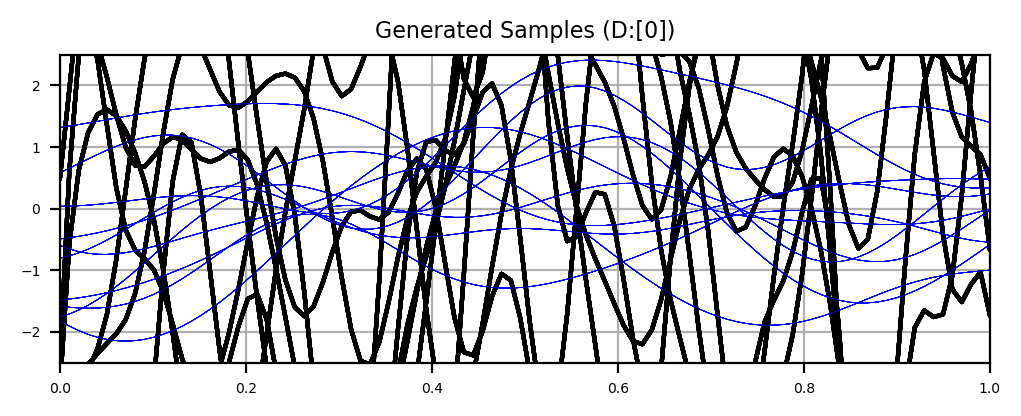

[10000/200000][5.00%] loss:[1.884]


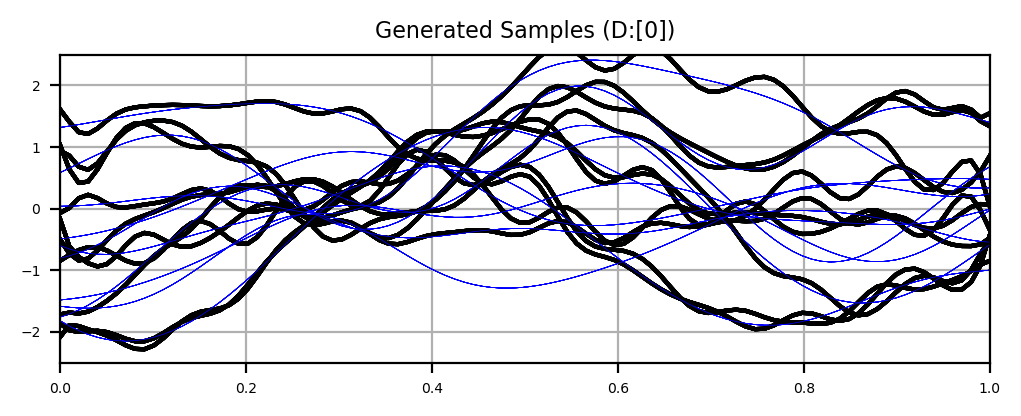

[20000/200000][10.00%] loss:[1.715]


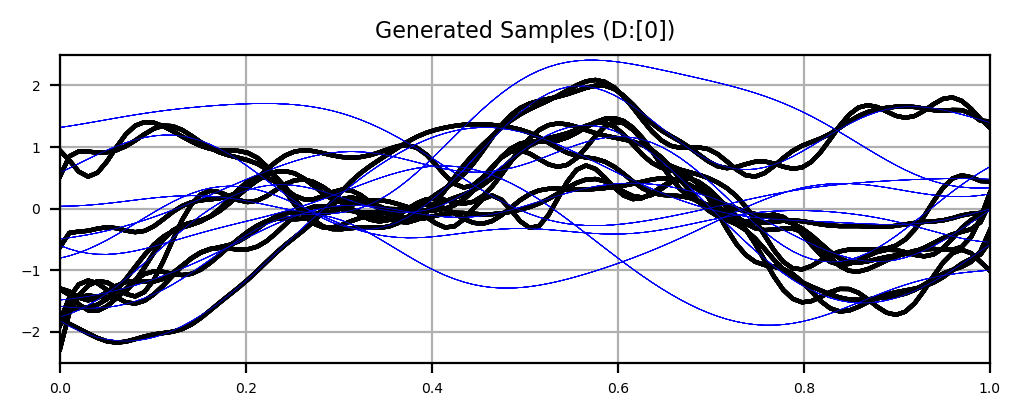

[30000/200000][15.00%] loss:[1.355]


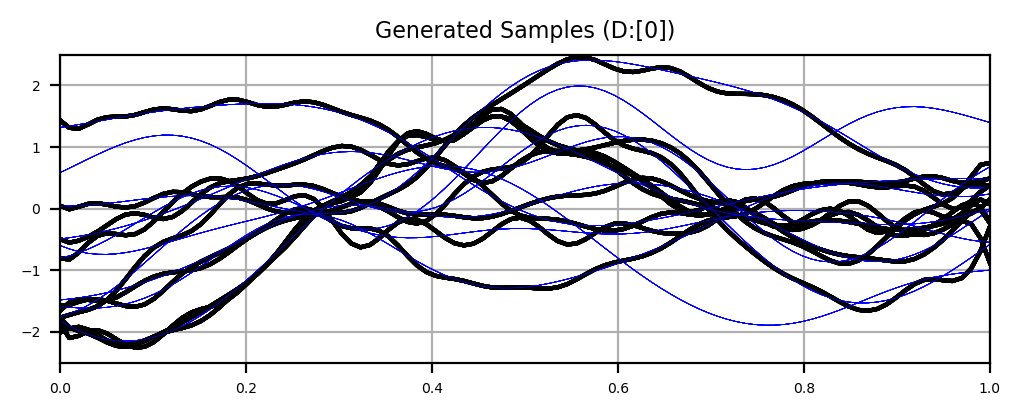

[40000/200000][20.00%] loss:[1.681]


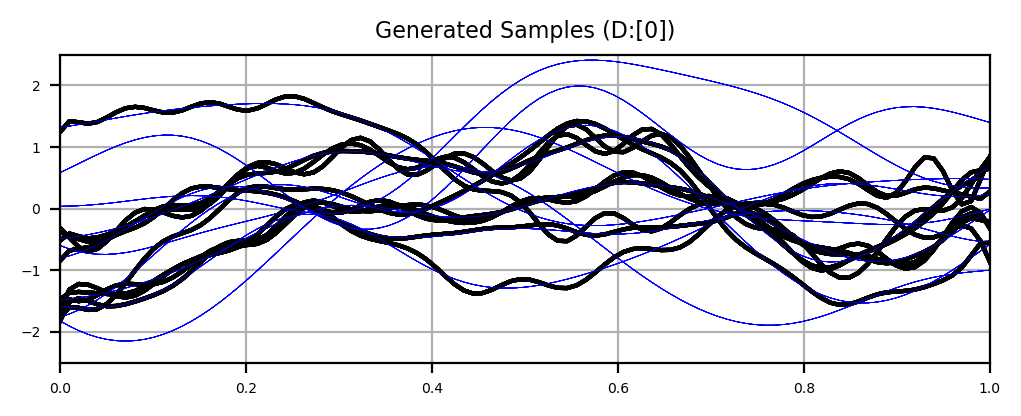

[50000/200000][25.00%] loss:[1.818]


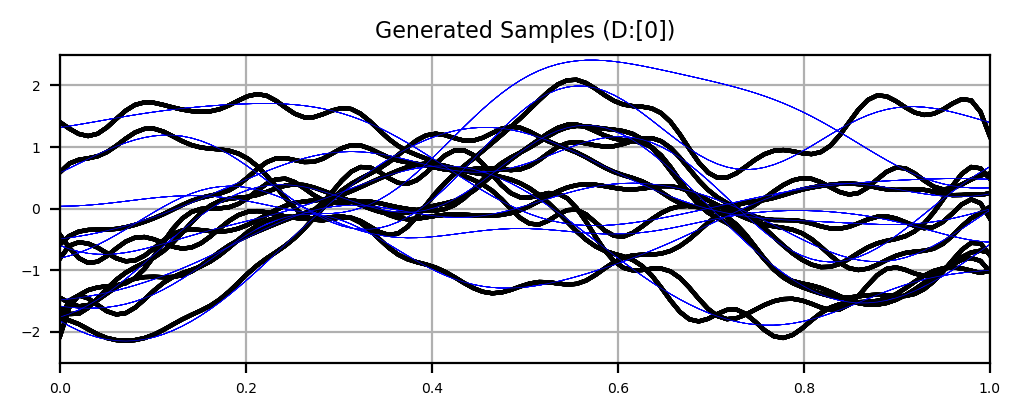

[60000/200000][30.00%] loss:[1.638]


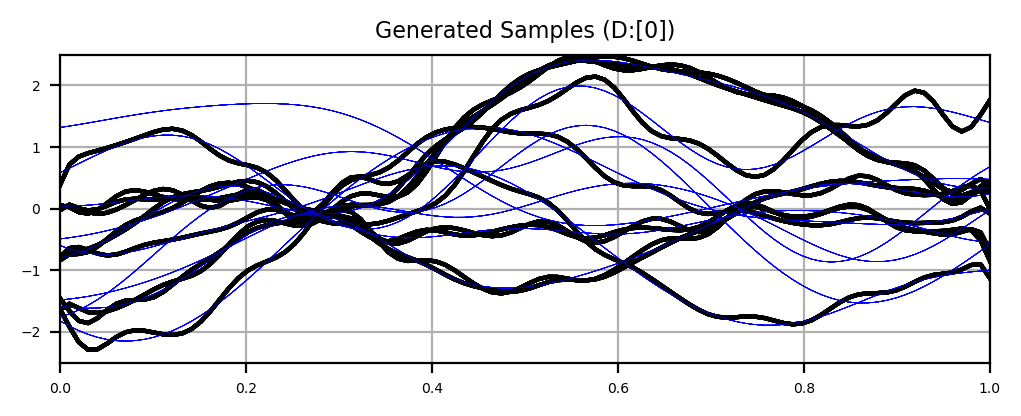

[70000/200000][35.00%] loss:[1.228]


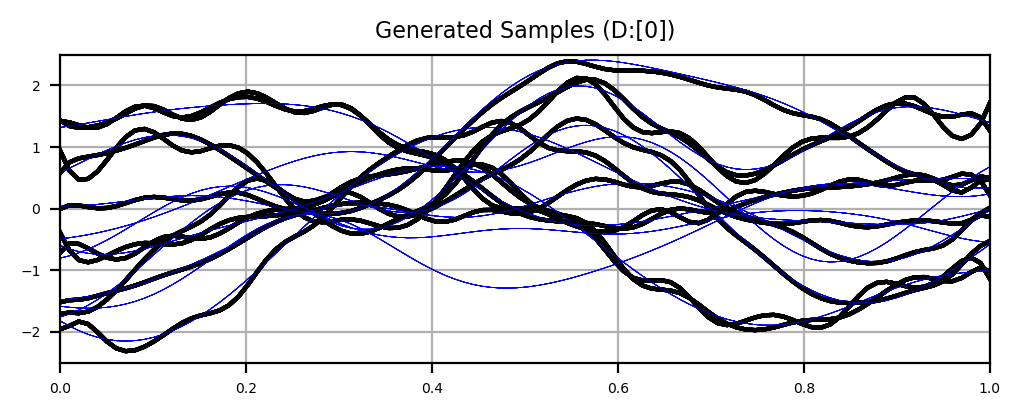

[80000/200000][40.00%] loss:[1.312]


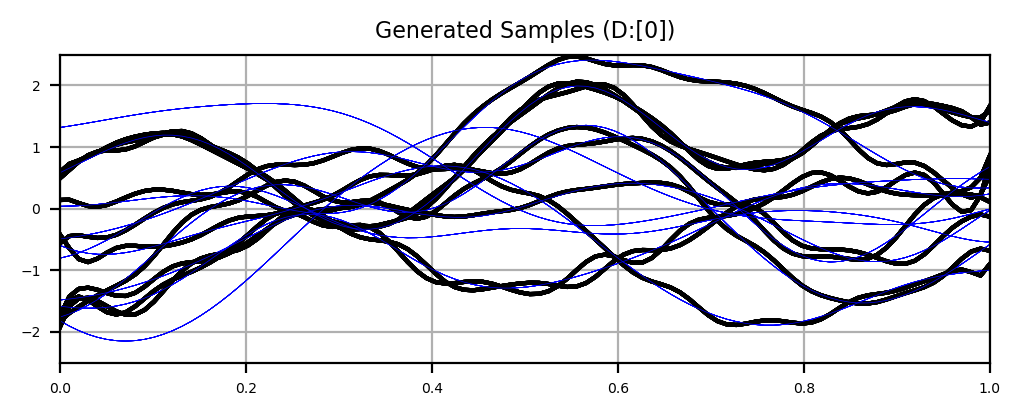

[90000/200000][45.00%] loss:[1.487]


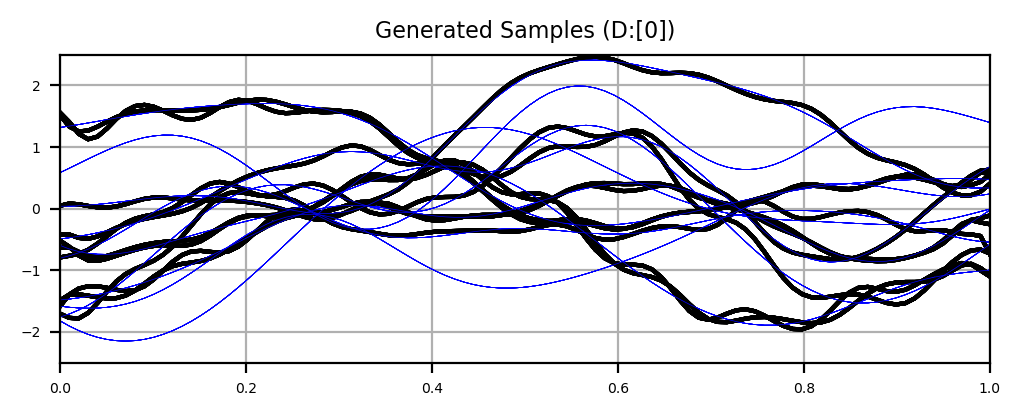

[100000/200000][50.00%] loss:[1.733]


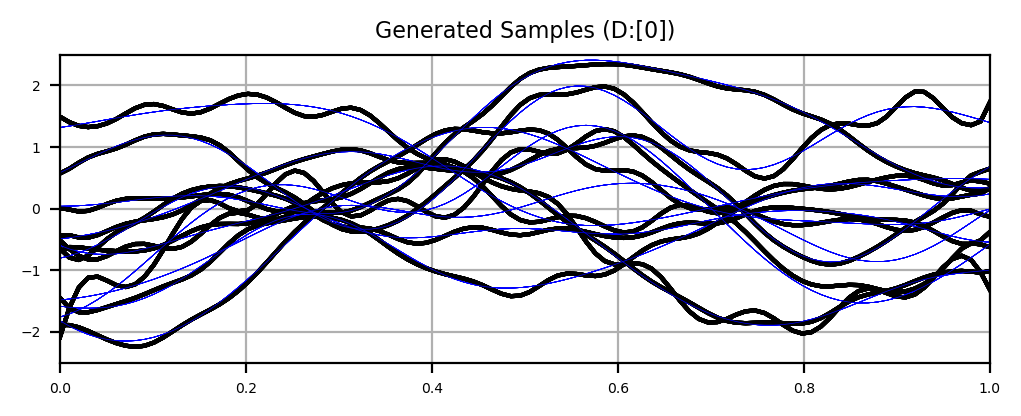

[110000/200000][55.00%] loss:[1.280]


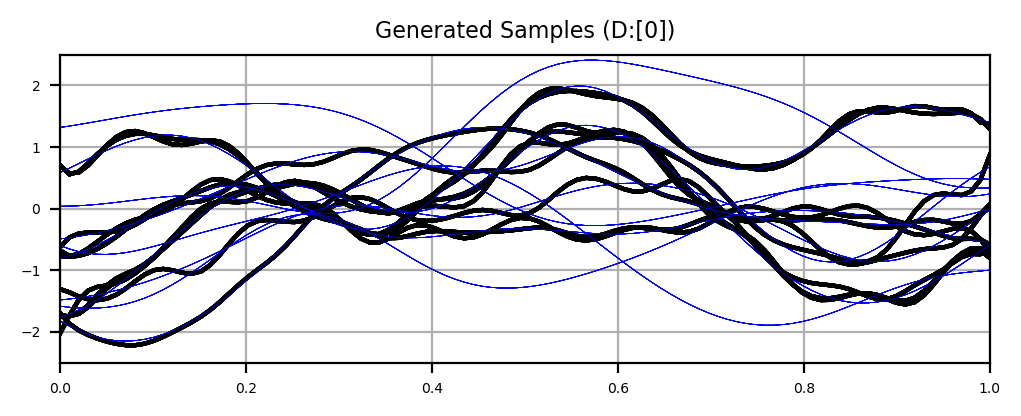

[120000/200000][60.00%] loss:[1.214]


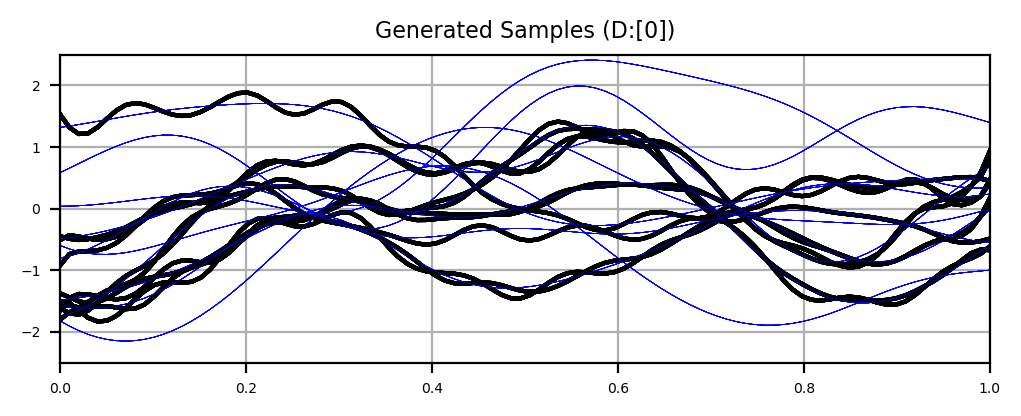

[130000/200000][65.00%] loss:[1.405]


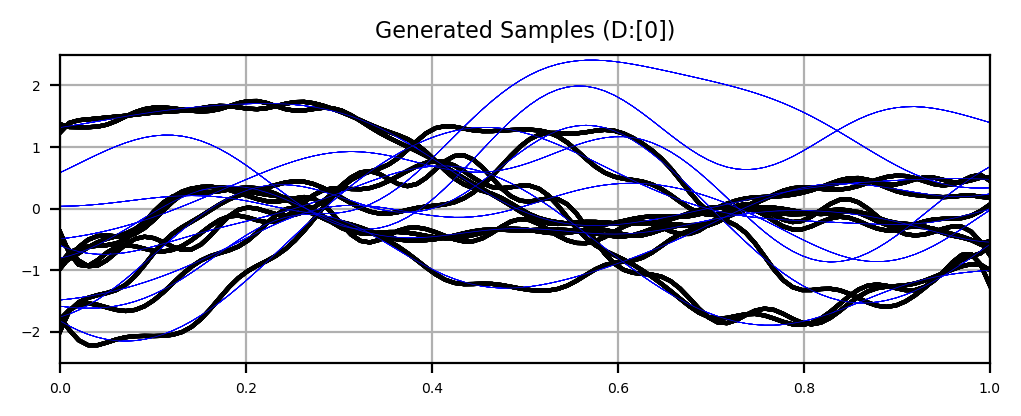

[140000/200000][70.00%] loss:[1.512]


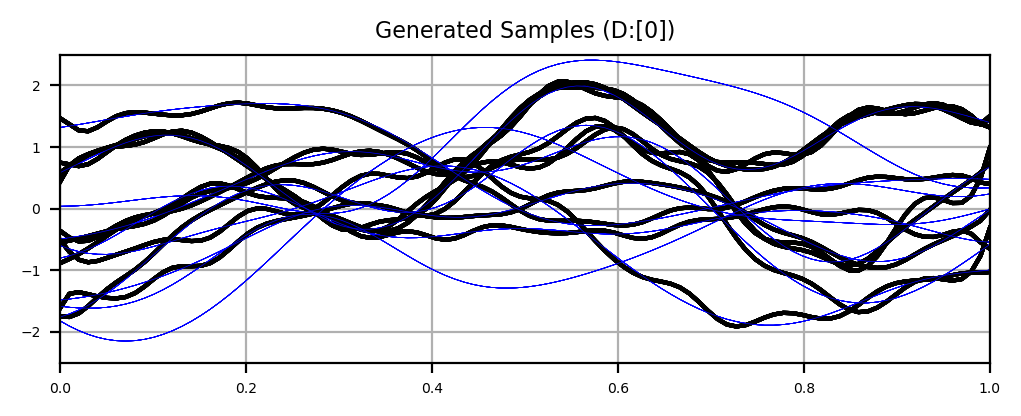

[150000/200000][75.00%] loss:[1.494]


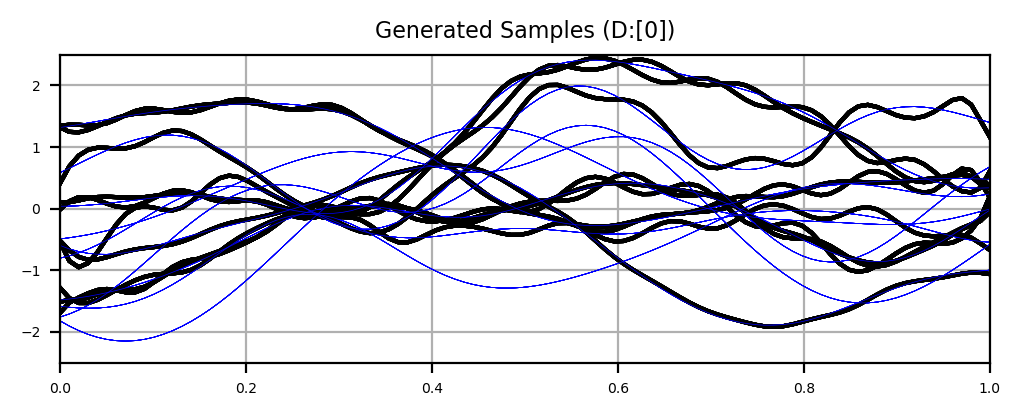

[160000/200000][80.00%] loss:[1.581]


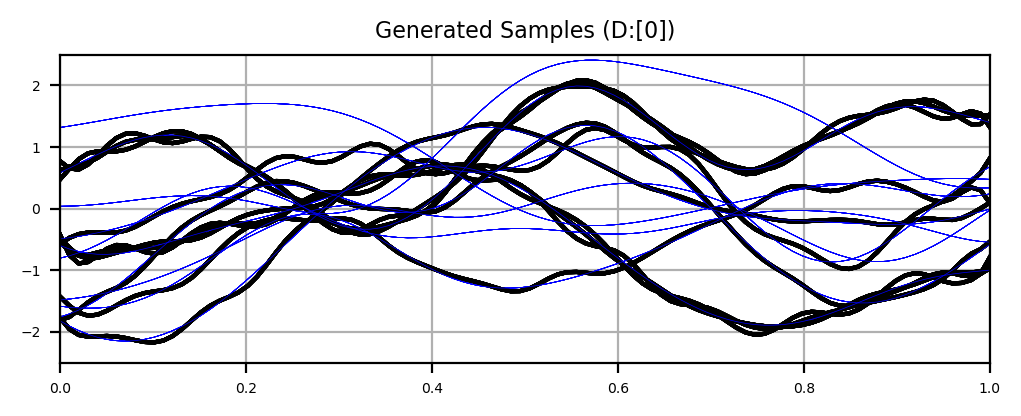

[170000/200000][85.00%] loss:[1.392]


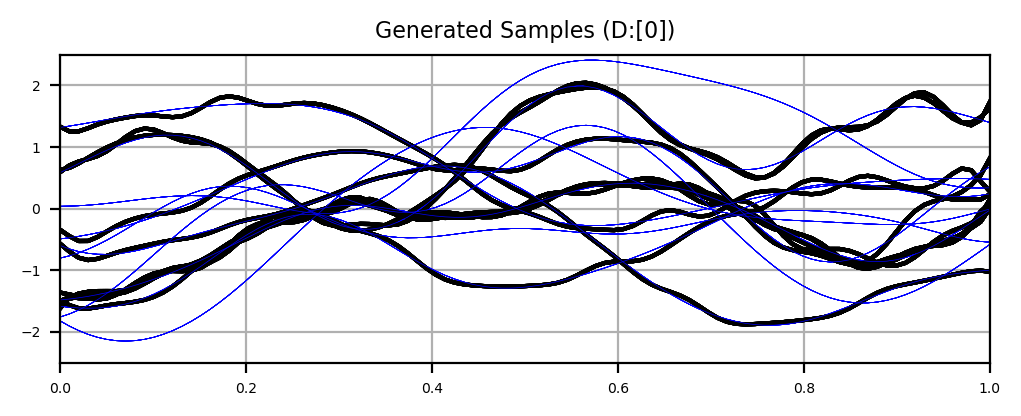

[180000/200000][90.00%] loss:[1.269]


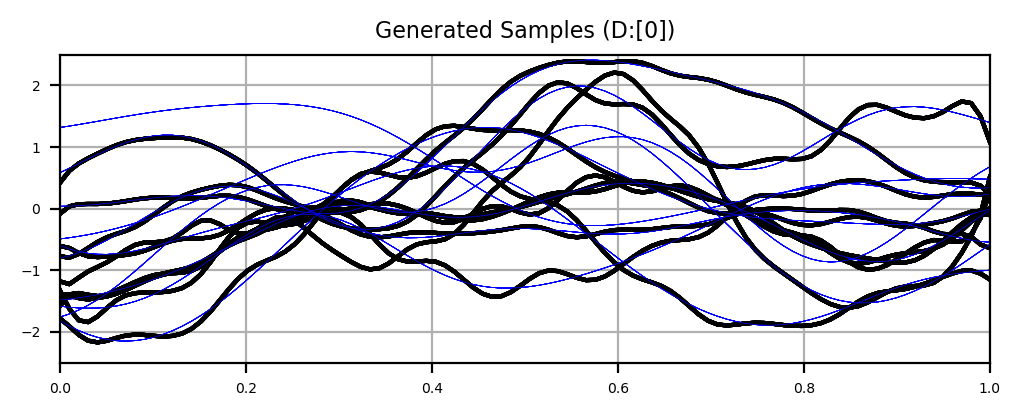

[190000/200000][95.00%] loss:[1.724]


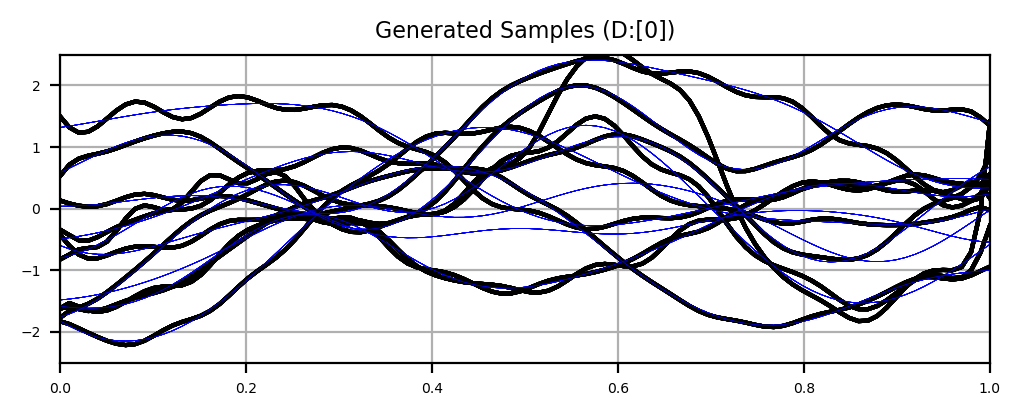

[199999/200000][100.00%] loss:[1.292]


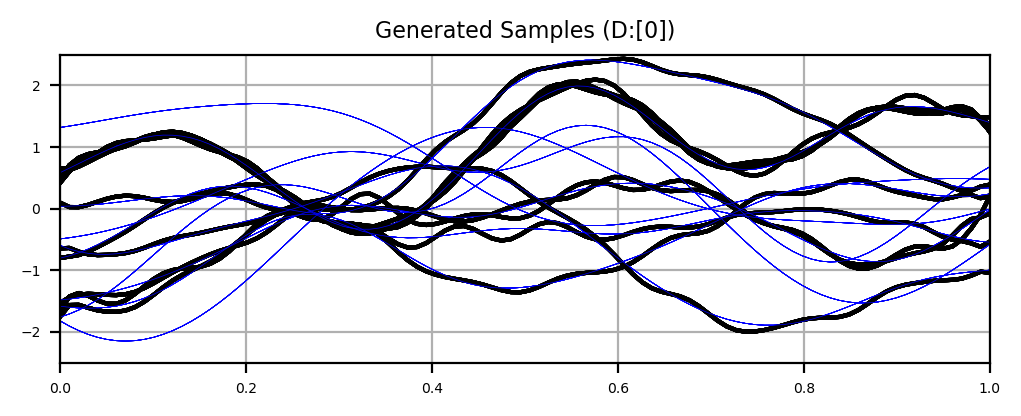

Done.


In [8]:
ddpm_train_wrapper(
    hyp_len_rkhs=0.1,
    l1_w=l1_w,l2_w=l2_w,huber_w=huber_w,smt_l1_w=smt_l1_w,
    vel_w=vel_w,acc_w=acc_w)
print ("Done.")

[0/200000][0.00%] loss:[12.785]


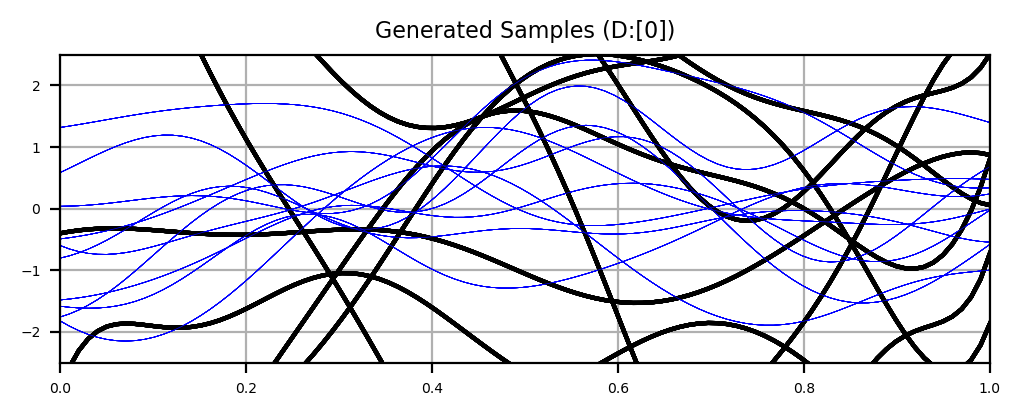

[10000/200000][5.00%] loss:[0.369]


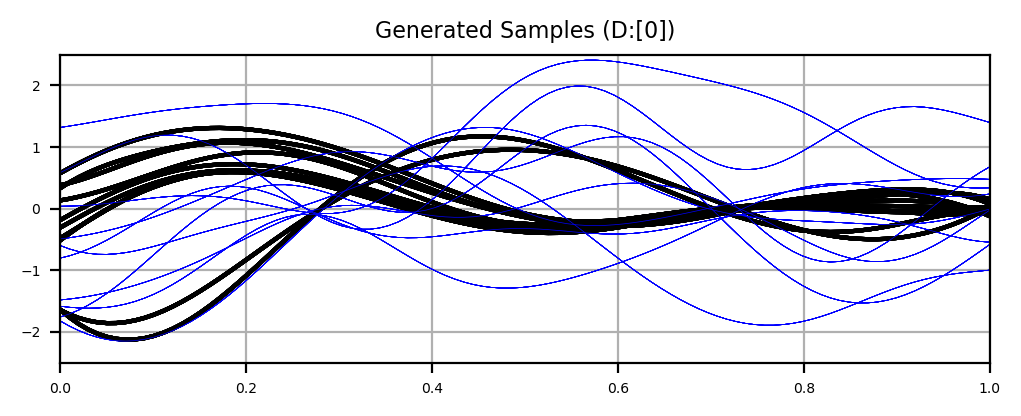

[20000/200000][10.00%] loss:[0.551]


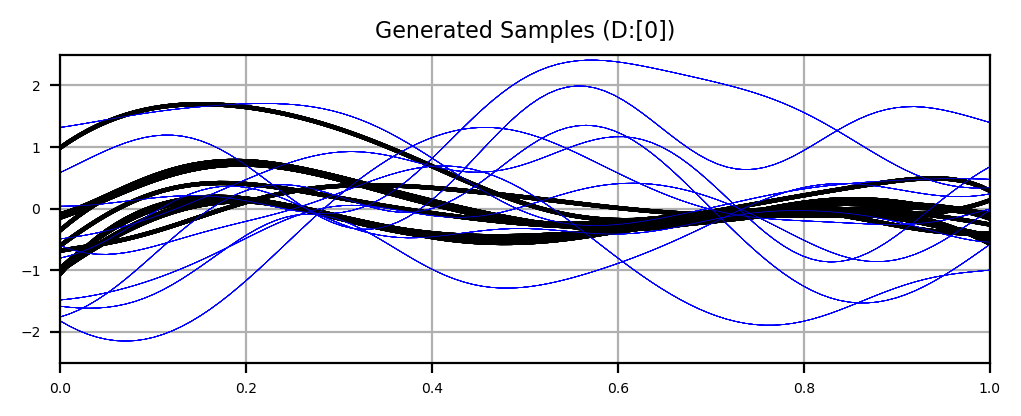

[30000/200000][15.00%] loss:[0.265]


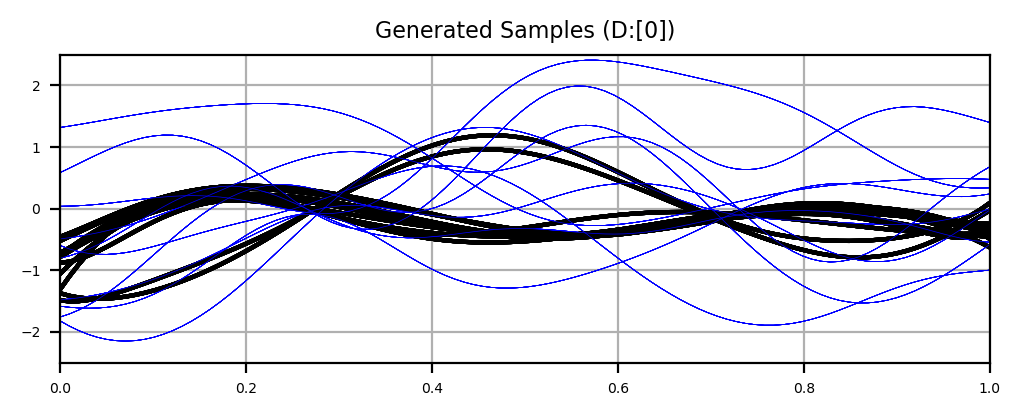

[40000/200000][20.00%] loss:[0.309]


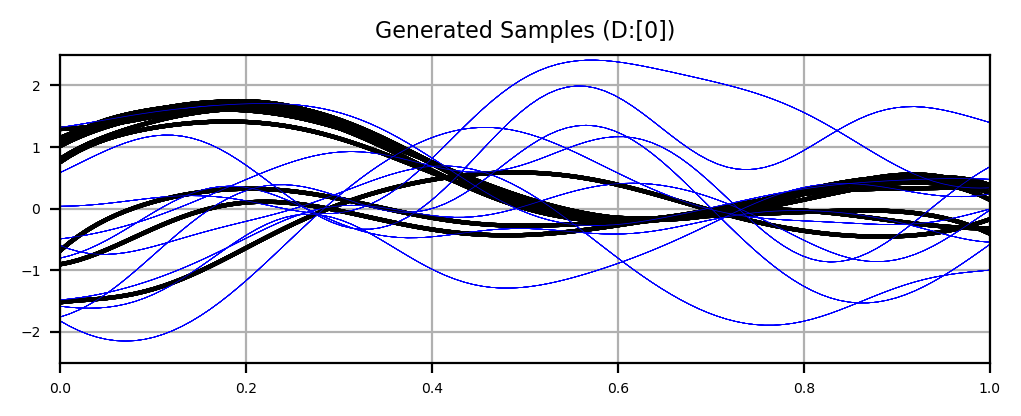

[50000/200000][25.00%] loss:[0.252]


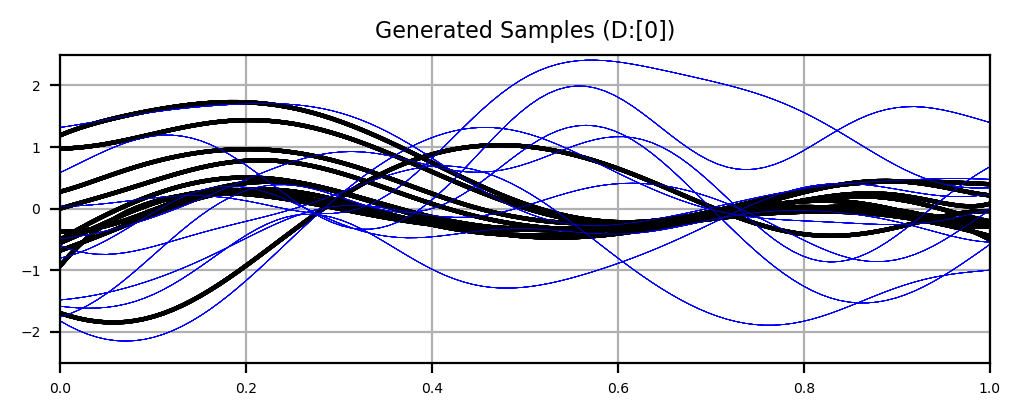

[60000/200000][30.00%] loss:[0.229]


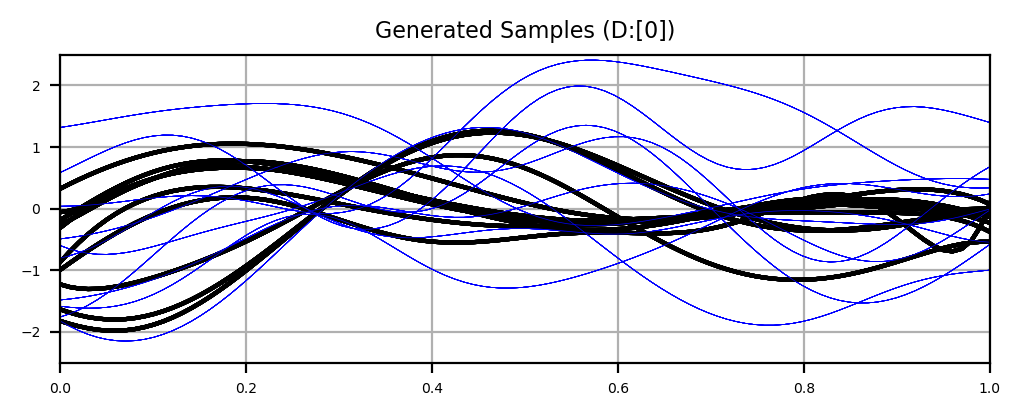

[70000/200000][35.00%] loss:[0.201]


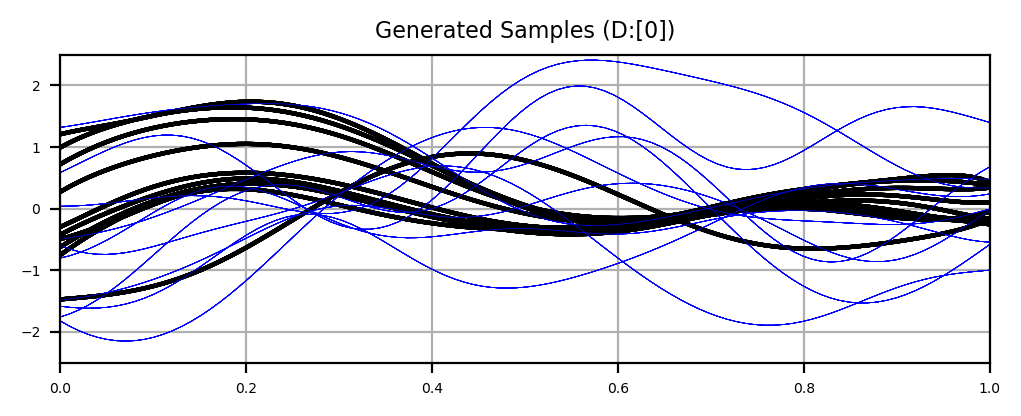

[80000/200000][40.00%] loss:[0.212]


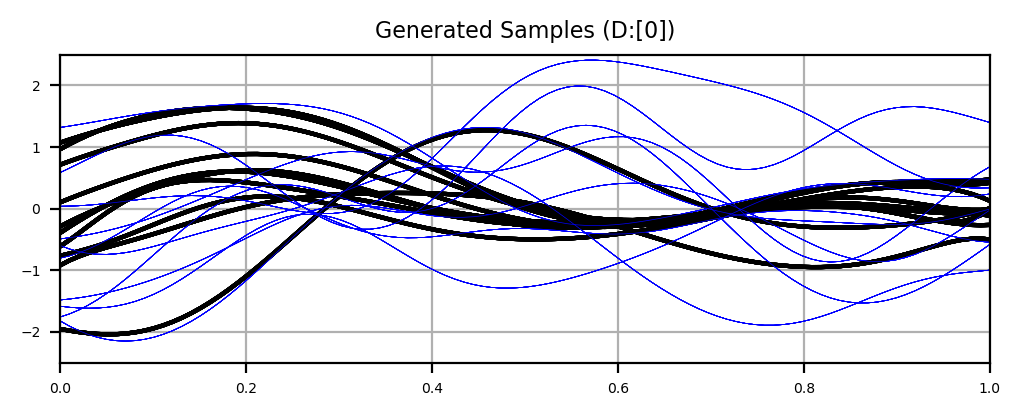

[90000/200000][45.00%] loss:[0.321]


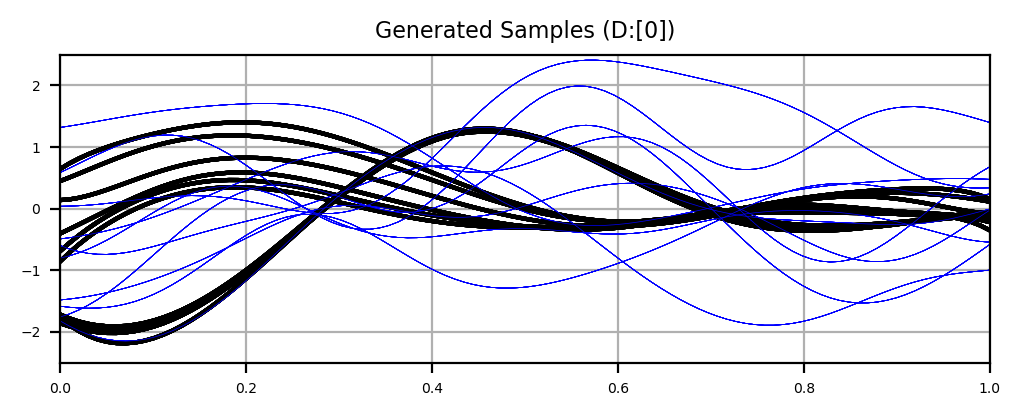

[100000/200000][50.00%] loss:[0.120]


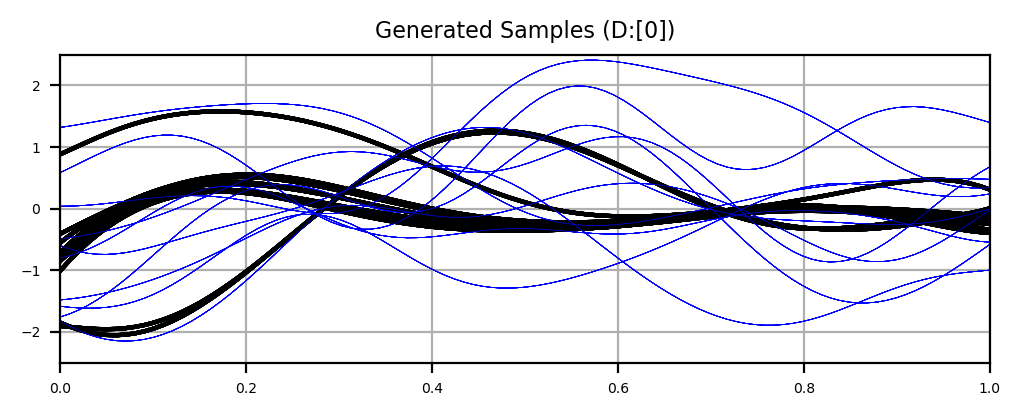

[110000/200000][55.00%] loss:[0.335]


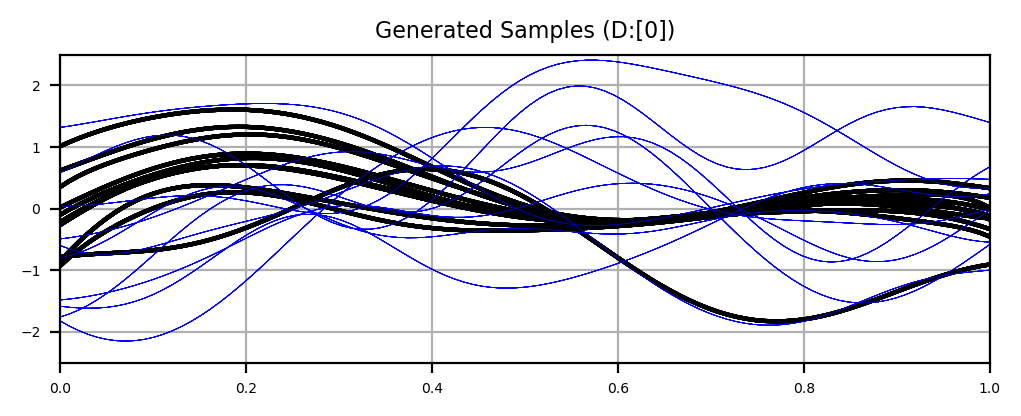

[120000/200000][60.00%] loss:[0.156]


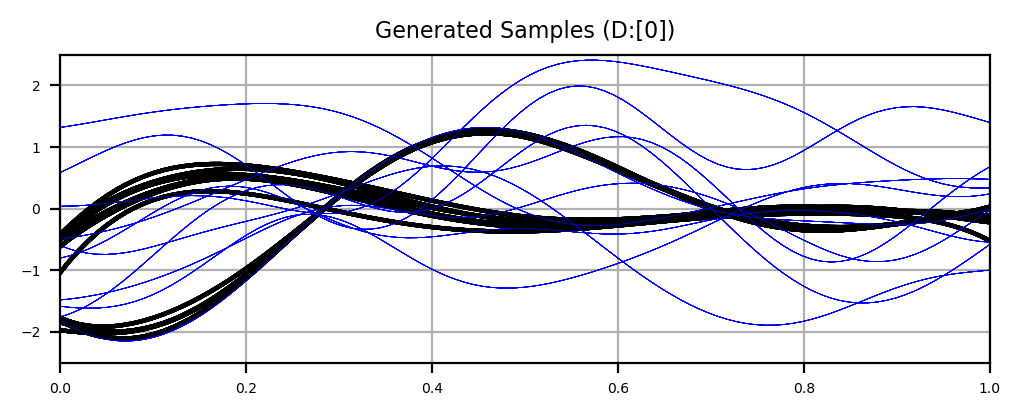

[130000/200000][65.00%] loss:[0.150]


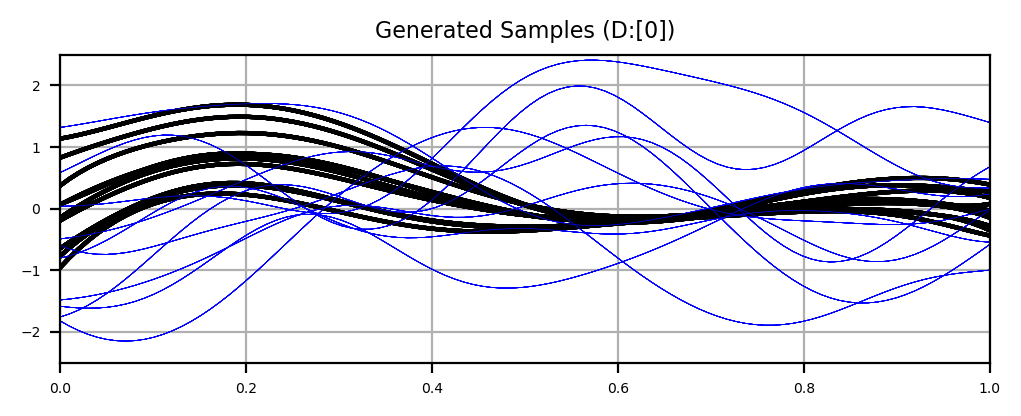

[140000/200000][70.00%] loss:[0.270]


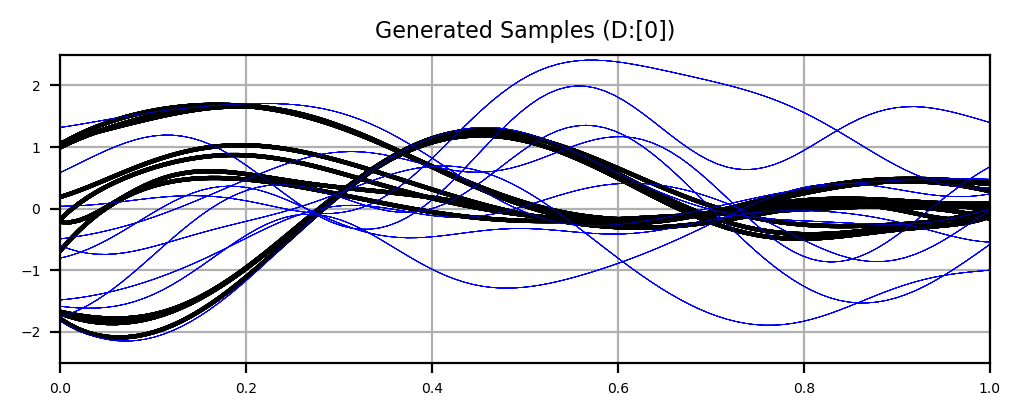

[150000/200000][75.00%] loss:[0.079]


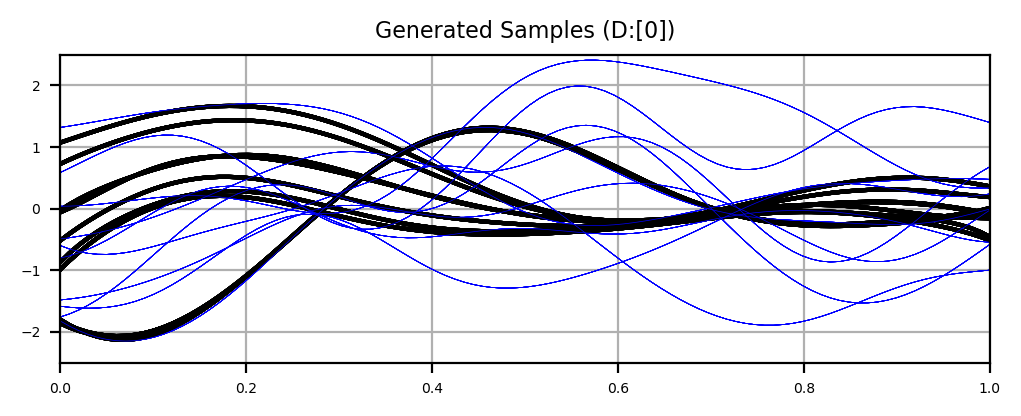

[160000/200000][80.00%] loss:[0.106]


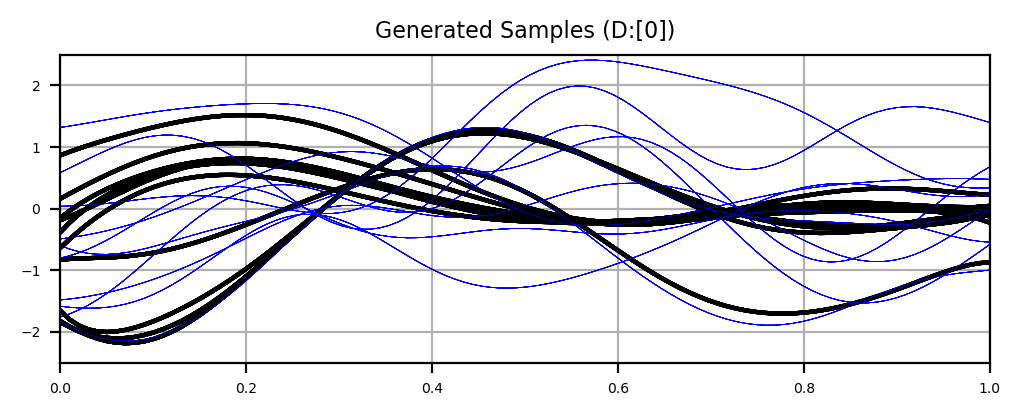

[170000/200000][85.00%] loss:[0.095]


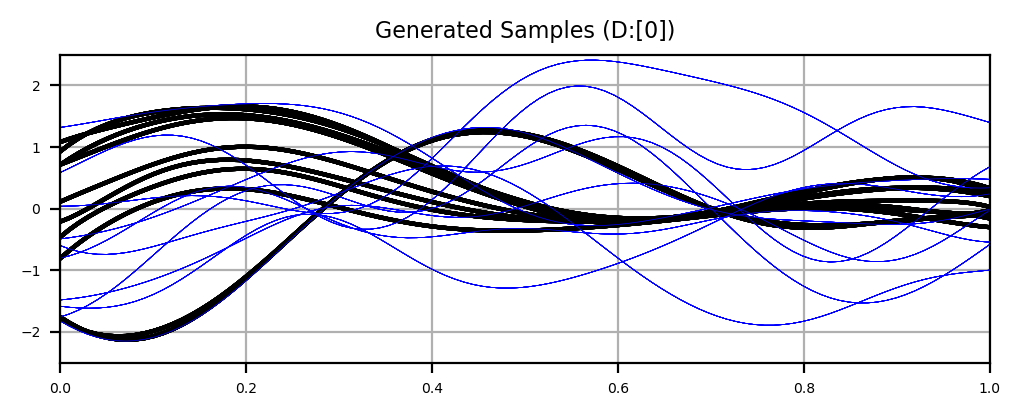

[180000/200000][90.00%] loss:[0.147]


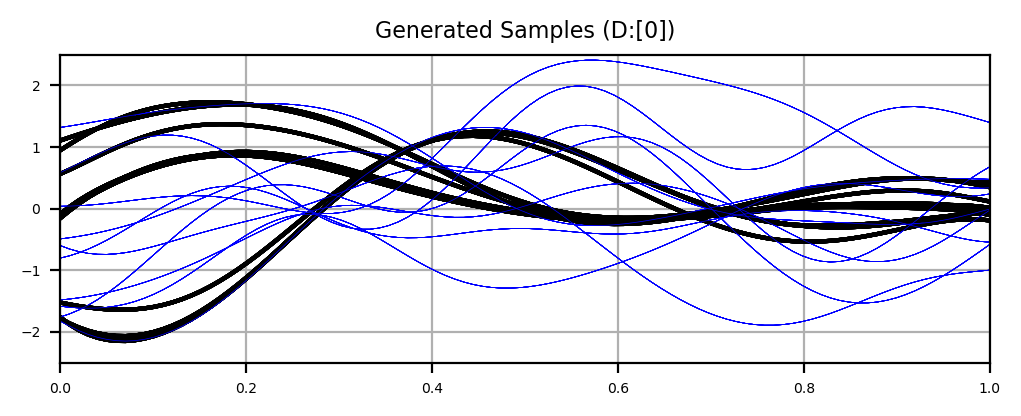

[190000/200000][95.00%] loss:[0.290]


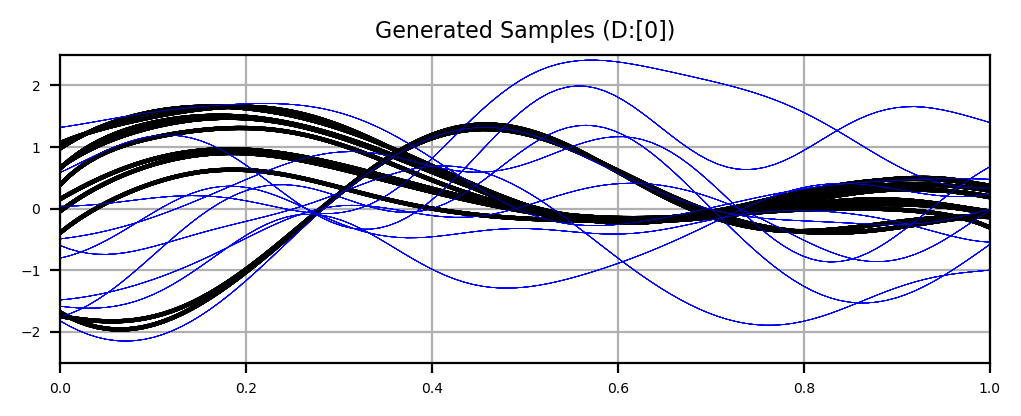

[199999/200000][100.00%] loss:[0.163]


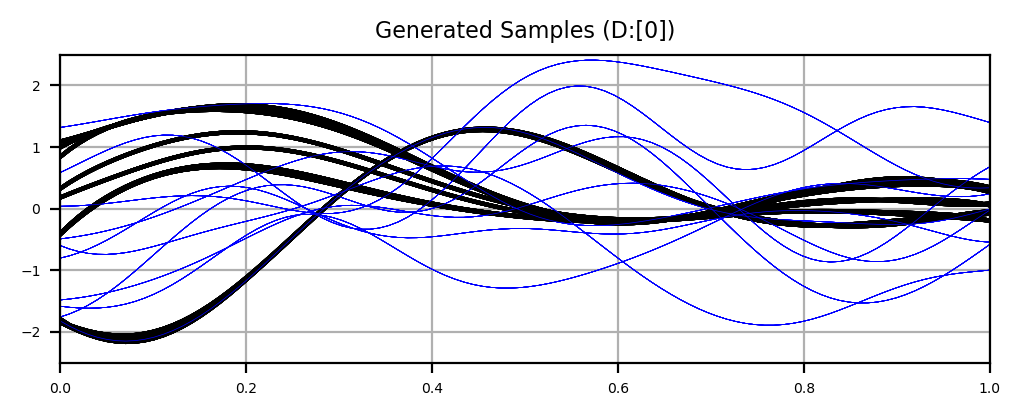

Done.


In [9]:
ddpm_train_wrapper(
    hyp_len_rkhs=0.5,
    l1_w=l1_w,l2_w=l2_w,huber_w=huber_w,smt_l1_w=smt_l1_w,
    vel_w=vel_w,acc_w=acc_w)
print ("Done.")

### Baseline

[0/200000][0.00%] loss:[20.978]


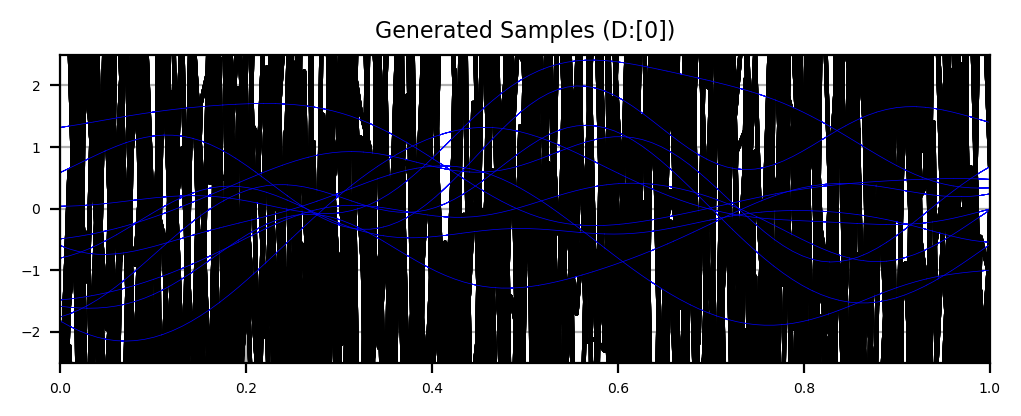

[10000/200000][5.00%] loss:[1.794]


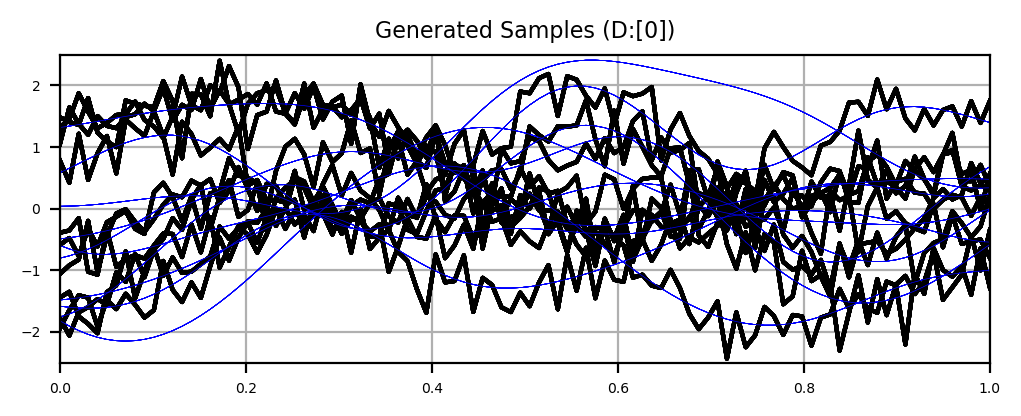

[20000/200000][10.00%] loss:[1.773]


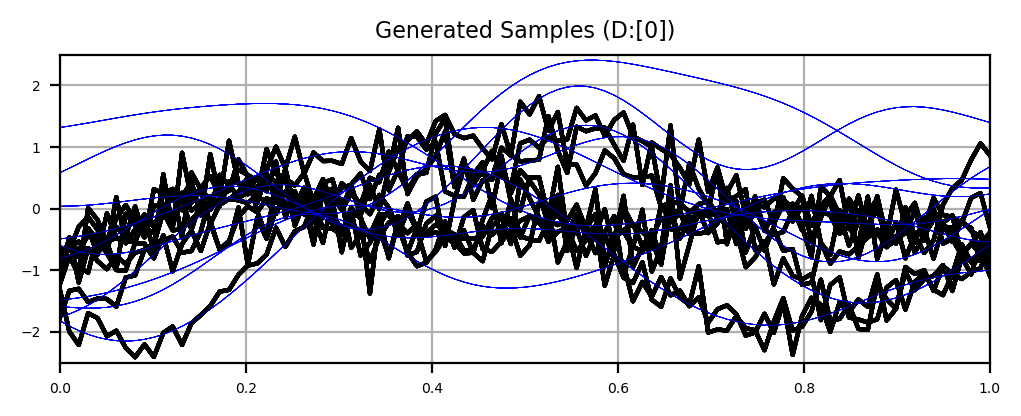

[30000/200000][15.00%] loss:[1.926]


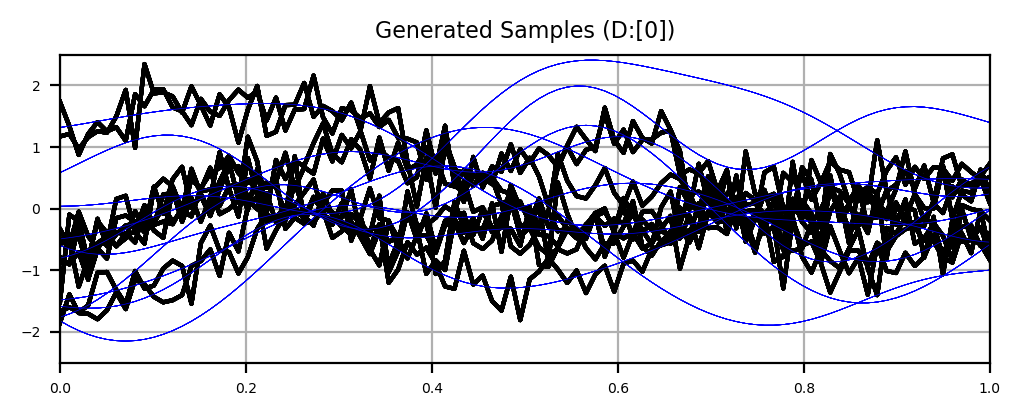

[40000/200000][20.00%] loss:[2.036]


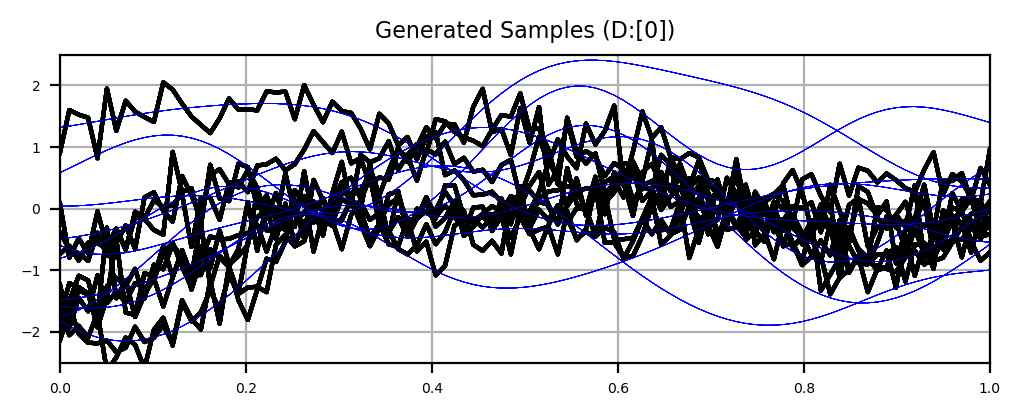

[50000/200000][25.00%] loss:[1.723]


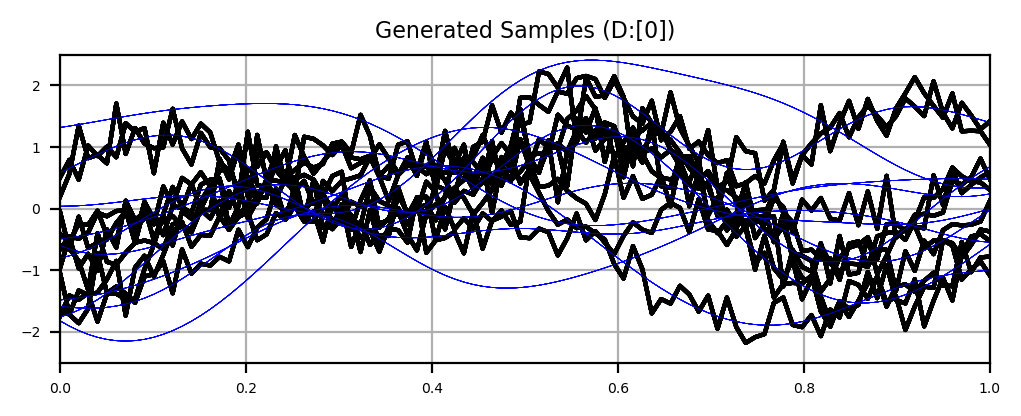

[60000/200000][30.00%] loss:[1.739]


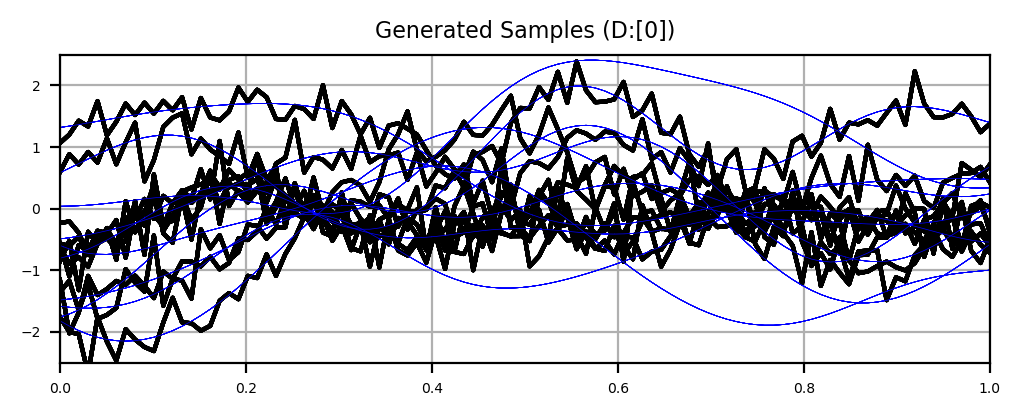

[70000/200000][35.00%] loss:[1.994]


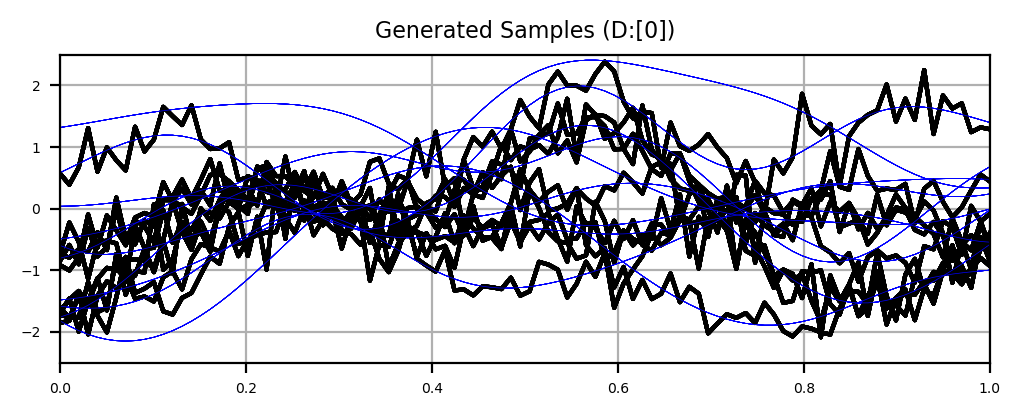

[80000/200000][40.00%] loss:[1.714]


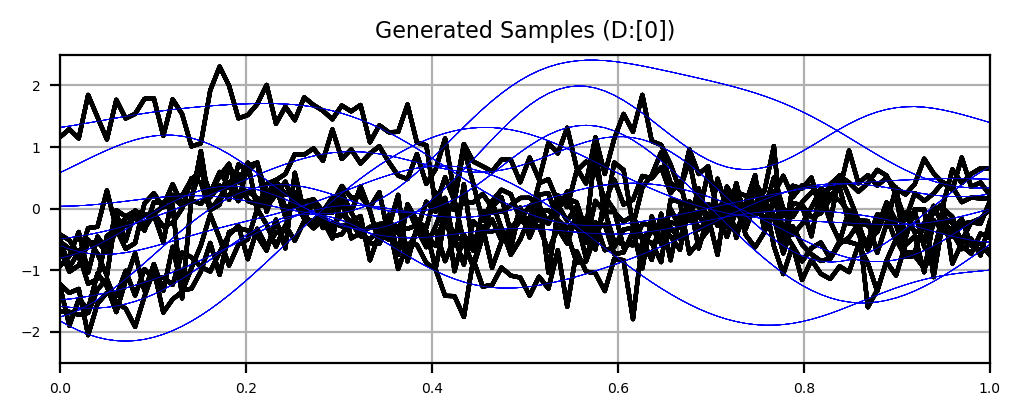

[90000/200000][45.00%] loss:[1.932]


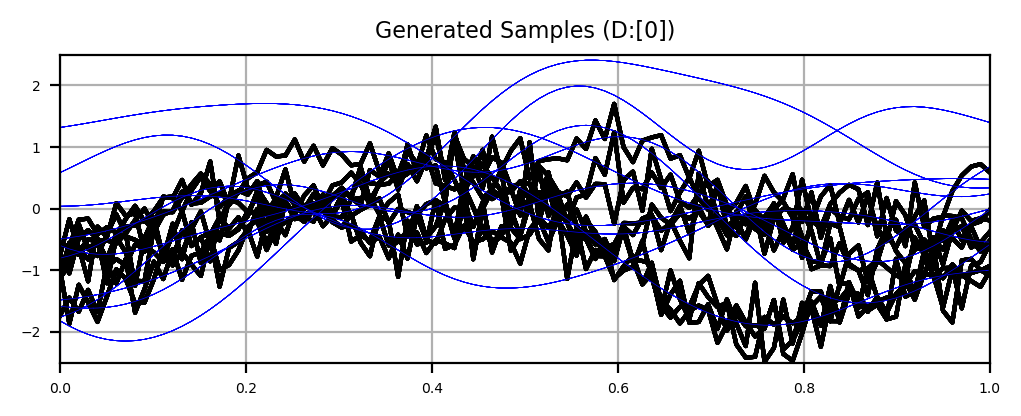

[100000/200000][50.00%] loss:[1.618]


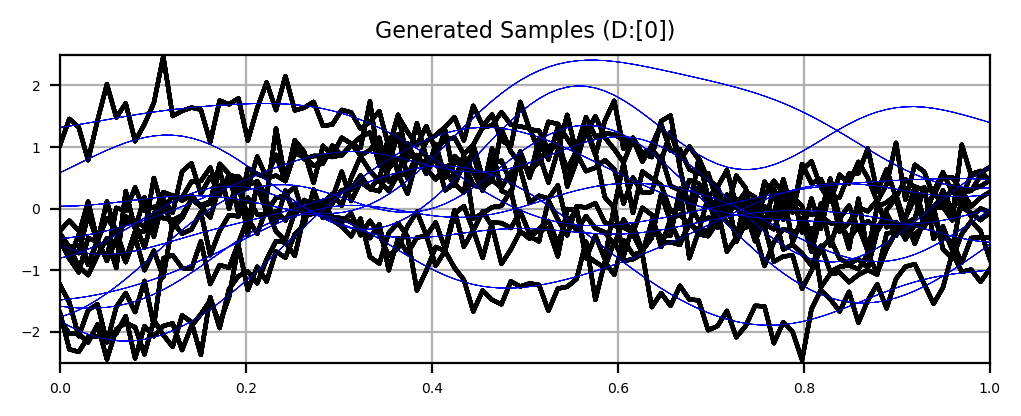

[110000/200000][55.00%] loss:[1.889]


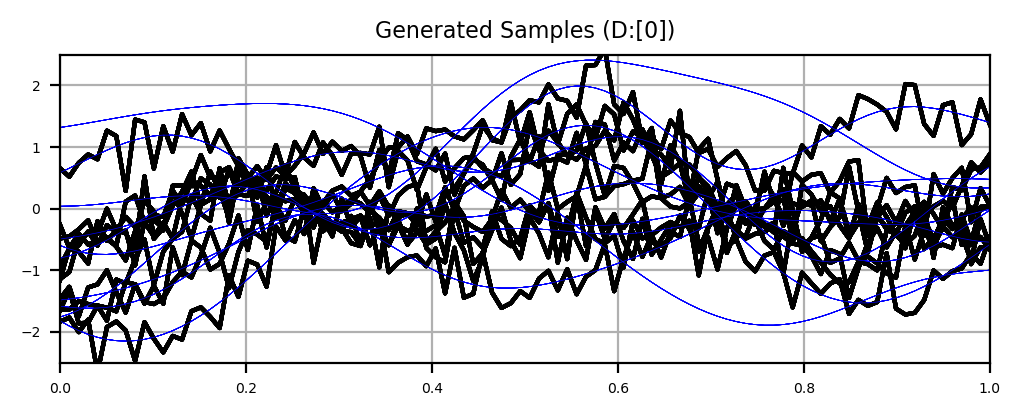

[120000/200000][60.00%] loss:[1.751]


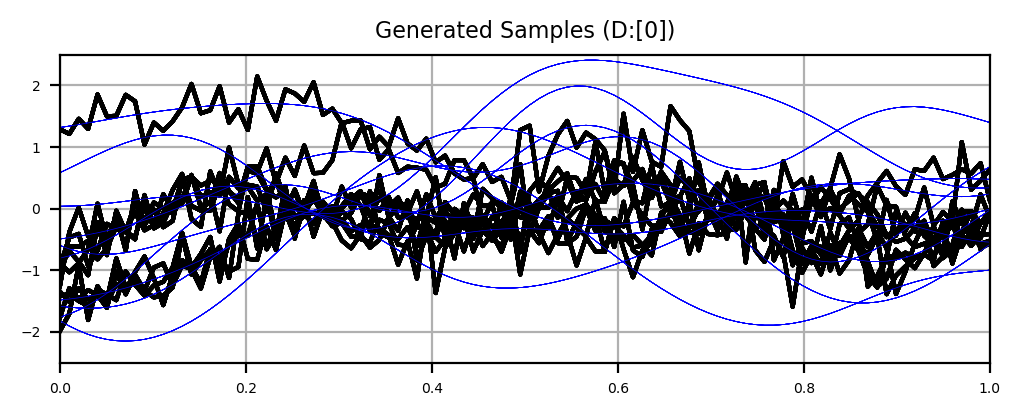

[130000/200000][65.00%] loss:[1.958]


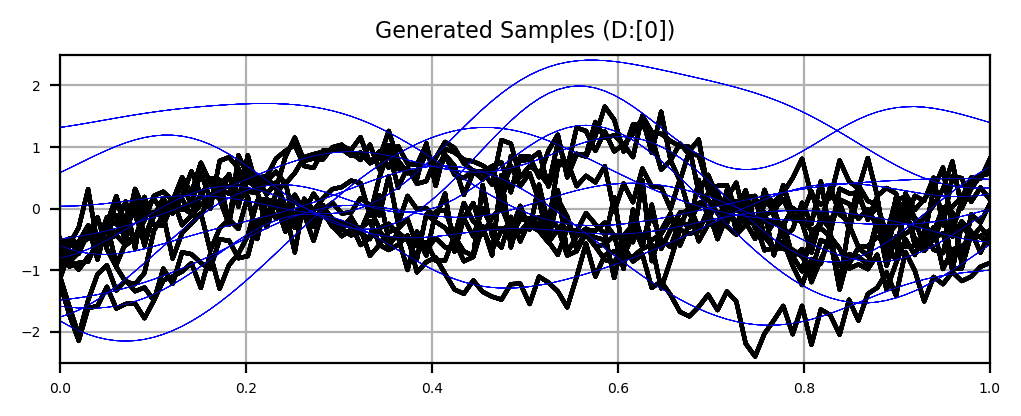

[140000/200000][70.00%] loss:[1.899]


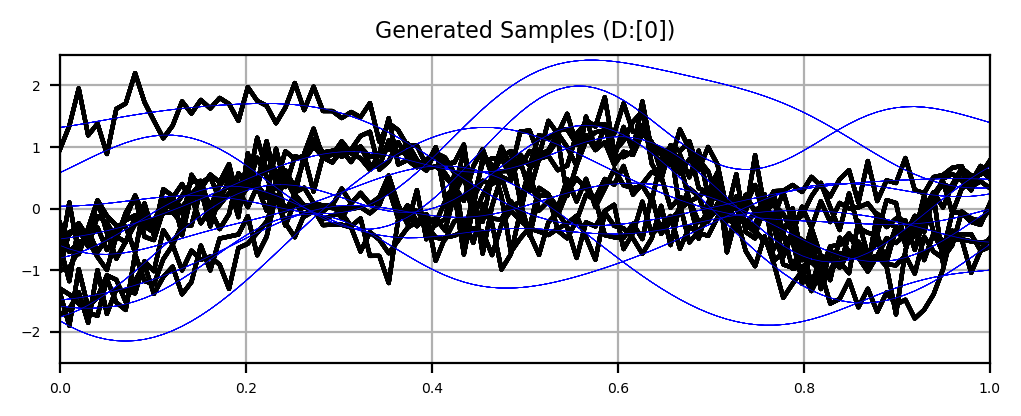

[150000/200000][75.00%] loss:[1.686]


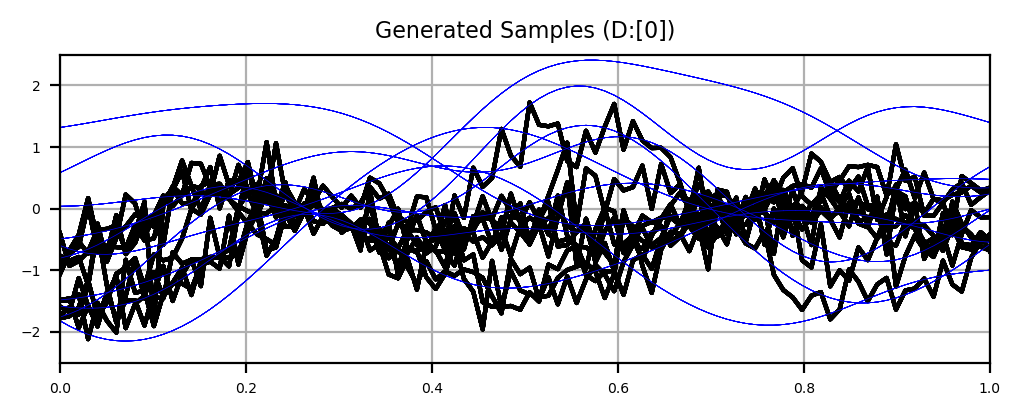

[160000/200000][80.00%] loss:[1.769]


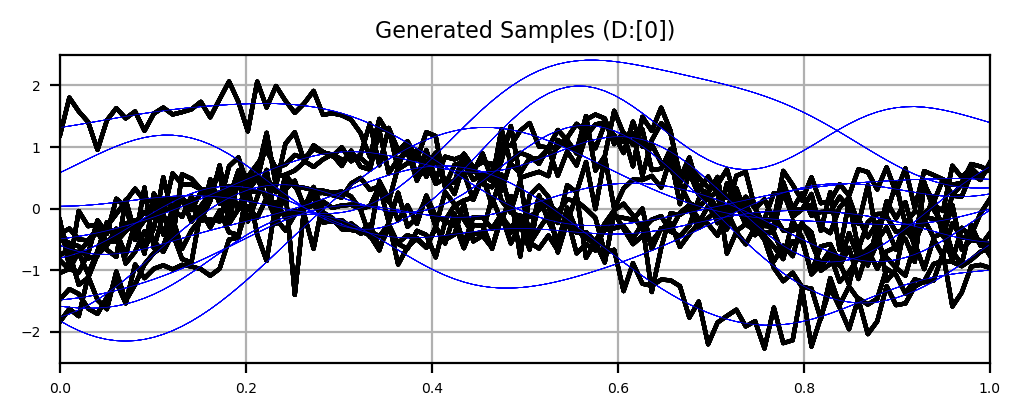

[170000/200000][85.00%] loss:[1.608]


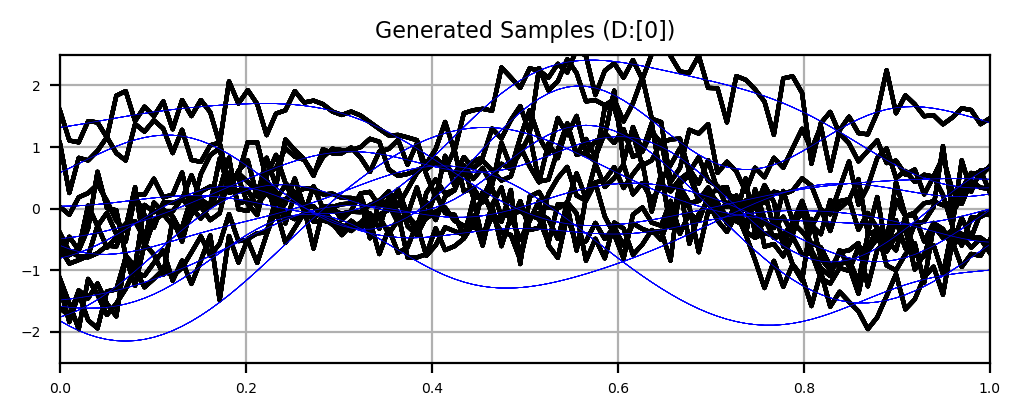

[180000/200000][90.00%] loss:[1.585]


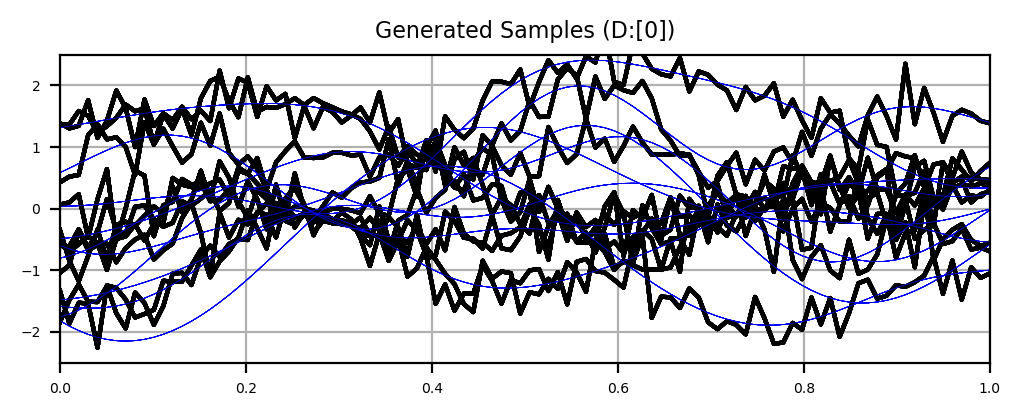

[190000/200000][95.00%] loss:[1.671]


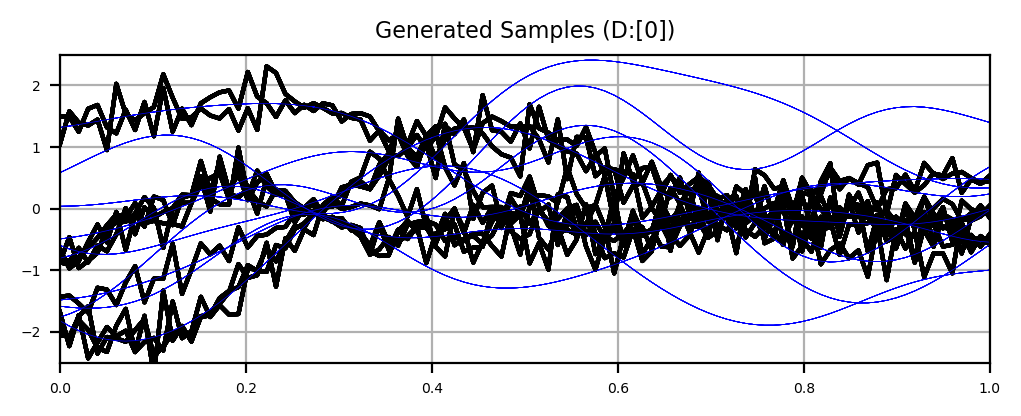

[199999/200000][100.00%] loss:[1.633]


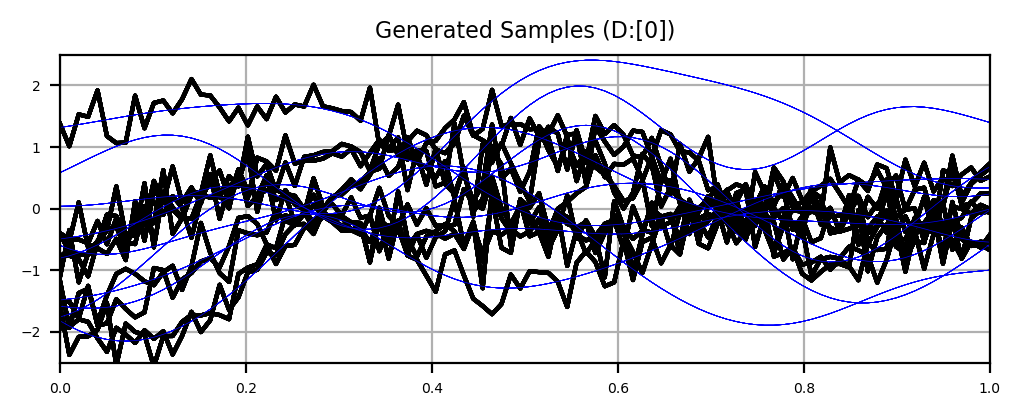

Done.


In [10]:
ddpm_train_wrapper(
    hyp_len_rkhs=0.0,
    l1_w=l1_w,l2_w=l2_w,huber_w=huber_w,smt_l1_w=smt_l1_w,
    vel_w=0.0,acc_w=0.0)
print ("Done.")